included nessasary libraries

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrices

In [ ]:

# Load the dataset
house_df = pd.read_csv("kc_house_data.csv")
house_df.head()

# Define features and target variable
features = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", 
            "condition", "grade", "sqft_above", "sqft_basement", "yr_built"]
target = "price"


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Simple linear regression

Intercept: -43580.743
Coefficient: 280.624


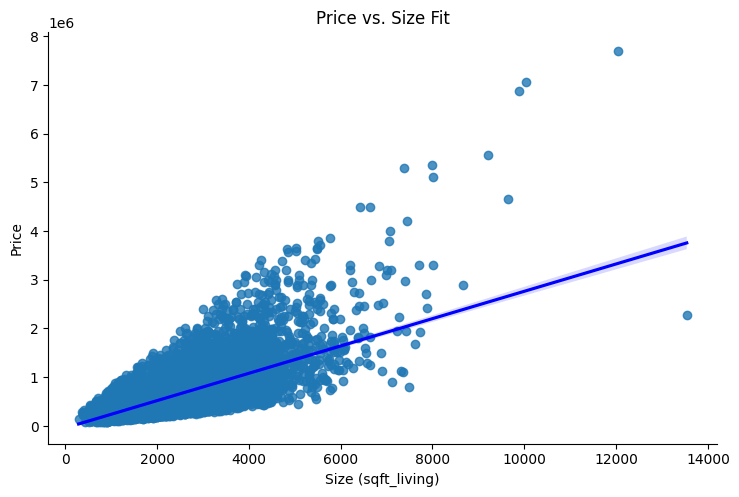

In [5]:

# Simple Linear Regression
X = house_df[["sqft_living"]]
y = house_df[target]

simple_lm = LinearRegression()
simple_lm.fit(X, y)

print(f'Intercept: {simple_lm.intercept_:.3f}')
print(f'Coefficient: {simple_lm.coef_[0]:.3f}')

# Scatter plot with regression line
sns.lmplot(x="sqft_living", y="price", data=house_df, aspect=1.5, line_kws={'color': 'blue'})
plt.title("Price vs. Size Fit")
plt.xlabel("Size (sqft_living)")
plt.ylabel("Price")
plt.show()

Multiple Linear Regression

In [ ]:

# Multiple Linear Regression
X = house_df[["sqft_living", "sqft_lot", "bathrooms", "grade"]]
y = house_df[target]

house_lm = LinearRegression()
house_lm.fit(X, y)

# Model Summary
predictions = house_lm.predict(X)
RMSE = np.sqrt(mean_squared_error(y, predictions))
R_squared = r2_score(y, predictions)

print(f'RMSE: {RMSE:.2f}')
print(f'R²: {R_squared:.4f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm.coef_):
    print(f' {name}: {coef:.3f}')

Intercept: -43580.743
Coefficient: 280.624


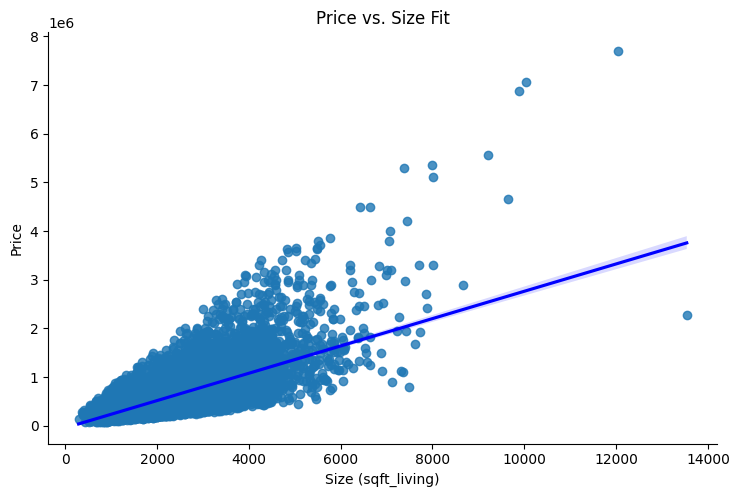

RMSE: 249532.23
R²: 0.5380
Coefficients:
 sqft_living: 206.465
 sqft_lot: -0.266
 bathrooms: -39443.458
 grade: 103669.740
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     6291.
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:30:06   Log-Likelihood:            -2.9926e+05
No. Observations:               21613   AIC:                         5.985e+05
Df Residuals:                   21608   BIC:                         5.986e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------

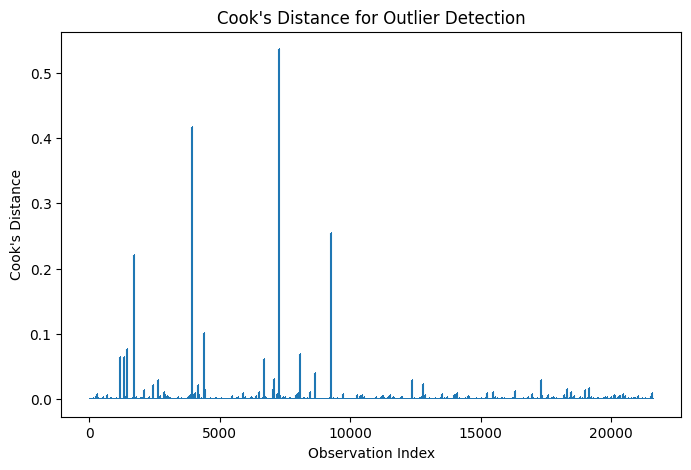

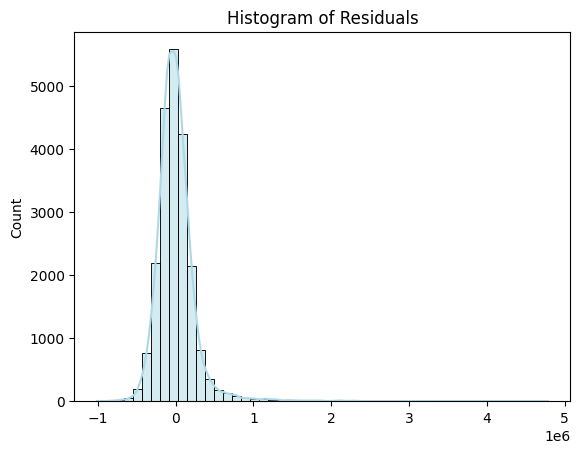

Durbin-Watson Test Statistic: 1.981
Intercept: -589946.648
Coefficients:
 sqft_living: 206.48383122200437
 sqft_lot: -0.26682705936198836
 bathrooms: -39394.3758697045
 grade: 103605.98459869105
 PropertyType_Single Family: -7452.230209897074
 PropertyType_Townhouse: -8649.540375562801


In [ ]:



# Stepwise Regression (Using statsmodels)
X = sm.add_constant(X)
stepwise_model = sm.OLS(y, X).fit()
print(stepwise_model.summary())

# Weighted Regression
house_df['Year'] = pd.to_datetime(house_df['date']).dt.year
house_df['Weight'] = house_df['Year'] - 2005

house_wt = sm.WLS(y, X, weights=house_df['Weight']).fit()
print(house_wt.summary())

# Outlier detection using Cook's Distance
influence = stepwise_model.get_influence()
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(8, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Outlier Detection")
plt.show()

# Residual Plot
residuals = stepwise_model.resid
sns.histplot(residuals, bins=50, kde=True, color="lightblue")
plt.title("Histogram of Residuals")
plt.show()

# Durbin-Watson Test for Autocorrelation
from statsmodels.stats.stattools import durbin_watson
print(f'Durbin-Watson Test Statistic: {durbin_watson(residuals):.3f}')

# Factor Variables (One-hot encoding)
house_df['PropertyType'] = np.random.choice(['Multiplex', 'Single Family', 'Townhouse'], size=len(house_df))
X = pd.get_dummies(house_df[['sqft_living', 'sqft_lot', 'bathrooms', 'grade', 'PropertyType']], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, y)

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')
